In [1]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


In [2]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['donor_tissue'] = df['donor'] + "_" + df['tissue']

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid_gex']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive = (df_clean.Immune_All_Low_predicted_labels == 'Naive B cells')
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
unhypermutated = df_clean.v_mismatch < 1
# print(df_clean.celltype.value_counts())
# df_clean.loc[naive & (df_clean.v_mismatch > 0), 'celltype'] = 'Memory B cells'
# print(df_clean.celltype.value_counts())

permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]


In [3]:
lineage_sizes = df.groupby(['donor', 'lineage_id'])['vdj_sequence'].nunique()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],axis=1)
df_clean['is_naive_for_lineage_designation'] = (df_clean['celltype'] == 'Naive B cells') & (df_clean.v_mismatch < 1)
naive_lineage = df_clean.groupby(['donor', 'lineage_id'])['is_naive_for_lineage_designation'].sum() > 1
df_clean['naive_lineage'] = df_clean.apply(lambda x: naive_lineage[(x.donor, x.lineage_id)],axis=1)

# Naively infer  differentiation rate from v_mismatch distribution among all observed cells

In [4]:
celltype_counts = df_clean.celltype.value_counts()
common_celltype = df_clean.celltype.map(celltype_counts) > 100
df_clean = df_clean[common_celltype]
celltype_counts = df_clean.celltype.value_counts()
df_hm_clean = df_clean[df_clean.v_mismatch>0]
df_hm_clean = df_hm_clean[~df_hm_clean.celltype.isin(['ABCs', 'GC B cells'])]



In [5]:
rate_dict = {}

terminal_fates = df_hm_clean.celltype[df_hm_clean.celltype.str.startswith('ASC')].unique()
print(terminal_fates)
for celltype in df_hm_clean.celltype.unique():
    if 'Naive' in celltype:
        continue
    else:
        print(celltype)

    is_terminal = df_hm_clean.celltype.isin(terminal_fates)

    if celltype in terminal_fates:
        relevant_df = df_hm_clean[df_hm_clean.v_mismatch>20]
    else:
        relevant_df = df_hm_clean[(~(is_terminal).astype(bool)) & (df_hm_clean.v_mismatch>20)]
    n = relevant_df.shape[0]

    differentiated = relevant_df.celltype == celltype
    not_differentiated = ~(differentiated.astype(bool))

    n_theta = 1000
    thetas = np.logspace(-5,-0.0001,n_theta).T
    thetas = thetas.repeat(n).reshape((n_theta,n)).T

    ms = relevant_df.v_mismatch.values.repeat(n_theta).reshape((n,n_theta))
    ps = np.exp(np.multiply(np.log(1 - thetas), ms-1))

    ps[differentiated,:] = ps[differentiated,:]*thetas[differentiated,:]
    ps[not_differentiated,:] = ps[not_differentiated,:] * (1 - thetas[not_differentiated,:])

    ps = np.log(ps)
    total_log_prob = ps.sum(axis=0)
    best_theta_pos = np.argmax(total_log_prob)
    best_theta = thetas[0,best_theta_pos]
    best_llh = total_log_prob[best_theta_pos]
    CI = thetas[0,total_log_prob - best_llh > -1.92]
    rate_dict.update({celltype: (best_theta, (CI[0], CI[-1]))})




['ASC-3' 'ASC-1' 'ASC-4' 'ASC-2']
ASC-3


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/472012266.py:32: RuntimeWarning: divide by zero encountered in log
  ps = np.log(ps)


ASC-1
ASC-4
ASC-2
Memory B cells


In [6]:
rate_df = pd.DataFrame(rate_dict).T
rate_df.columns = ['theta_hat', 'theta_CI']
rate_df['theta_CI_lower'] = rate_df['theta_CI'].map(lambda x: x[0])
rate_df['theta_CI_upper'] = rate_df['theta_CI'].map(lambda x: x[1])
total_rate = rate_df['theta_hat'].sum()
rate_df['relative_rate'] = rate_df['theta_hat']/total_rate
rate_df

,theta_hat,theta_CI,theta_CI_lower,theta_CI_upper,relative_rate
ASC-3,0.005404,"(0.005280417579905884, 0.005529525788899481)",0.005280,0.005530,0.11453
ASC-1,0.005043,"(0.0049276384897981775, 0.005160104043930251)",0.004928,0.005160,0.106878
ASC-4,0.000082,"(6.394251141623246e-05, 0.00010375181328969038)",0.000064,0.000104,0.001746
ASC-2,0.001294,"(0.001221927236780036, 0.0013711797612431234)",0.001222,0.001371,0.027435
Memory B cells,0.035357,"(0.03495205158536773, 0.03576699734615815)",0.034952,0.035767,0.74941


In [7]:
all_cell_v_mismatch = df_clean.v_mismatch.values
all_v_mismatch = df_hm_clean.v_mismatch.values

In [8]:
from sklearn.linear_model import LinearRegression


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/1794313221.py:19: RuntimeWarning: invalid value encountered in log
  log_data_ccdf = np.log(data_ccdf)
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/1794313221.py:19: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(data_ccdf)


ASC-1 20 73
ASC-1 0.02951111401690265 -1.9121554627864534
ASC-2 20 62
ASC-2 0.029340991601123245 -1.6440467214989671
ASC-3 20 71
ASC-3 0.033148678908442086 -1.6399998912736105
ASC-4 20 32
ASC-4 0.029474461946751518 -1.3075514063483127
Memory B cells 20 68
Memory B cells 0.04098848033710778 -1.3842362794066778
Naive B cells 2 41
Naive B cells 0.03977774596230155 0.4497722195091307
../figures/paper figures/exponential_model.pdf


,ASC-1,ASC-2,ASC-3,ASC-4,Memory B cells,Naive B cells
0.0,3891.692105,820.558361,4662.033929,45.718187,38158.107278,504.030516
1.0,3521.873024,743.016469,4166.529040,41.378895,33189.412983,440.246644
2.0,3187.197050,672.802203,3723.688953,37.451462,28867.708928,384.534471
3.0,2884.324610,609.223110,3327.916183,33.896798,25108.748359,335.872541
4.0,2610.233483,551.652174,2974.208174,30.679520,21839.254571,293.368664
...,...,...,...,...,...,...
92.0,0.398638,0.088694,0.150967,0.004738,0.101756,0.001979
93.0,0.360756,0.080313,0.134921,0.004288,0.088506,0.001729
94.0,0.326474,0.072723,0.120581,0.003881,0.076981,0.001510
95.0,0.295450,0.065851,0.107765,0.003513,0.066957,0.001319


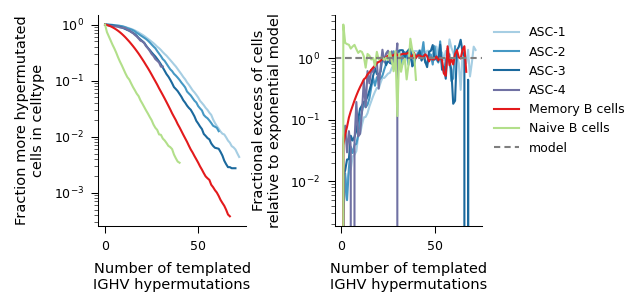

In [9]:
fig, ax = plt.subplots(1,2, figsize=(3,1.8))
V=0.3
parameter_dict = {'state':[],'slope':[], 'rate':[], 'offset':[]}

bins = np.arange(0,max(all_v_mismatch+2))-0.5
bin_centers = (bins[1:] + bins[:-1])/2

p_celltype = pd.DataFrame(index=bin_centers)

for ct in sorted(df_hm_clean.celltype.unique()):


    data_distribution = df_hm_clean[(df_hm_clean.celltype==ct)].v_mismatch.values
    data_distribution, bins = np.histogram(data_distribution, bins = np.arange(0,max(all_v_mismatch+2))-0.5)
    data_distribution = data_distribution/data_distribution.sum()
    norm20 = data_distribution[:20].sum()
    data_distribution  = data_distribution
    data_ccdf = 1 - data_distribution.cumsum()
    log_data_ccdf = np.log(data_ccdf)

    total_cells = len(df_hm_clean[df_hm_clean.celltype==ct].v_mismatch.values)
    if ct == 'Naive B cells':
        begin = 2
    else:
        begin = 20
    cutoff = np.argwhere(log_data_ccdf < np.log(20/total_cells))[0][0]
    print(ct, begin, cutoff)
    
    
    X=bin_centers[begin:cutoff].reshape(-1, 1)
    Y = -log_data_ccdf[begin:cutoff].reshape(-1, 1)
    reg = LinearRegression().fit(X,Y)
    # print(reg.score(X, Y))
    b = reg.coef_[0][0]
    a = reg.intercept_[0]
    print(ct, 1 - np.exp(-V*b), a)
    parameter_dict['state'].append(ct)
    parameter_dict['slope'].append(b)
    parameter_dict['offset'].append(a)
    parameter_dict['rate'].append( 1 - np.exp(-V*b))
    
    ax[0].plot(bin_centers[:cutoff], (data_ccdf[:cutoff]), color=bcelltype_colors_alt[ct], label=ct)

    ax[1].set_ylabel('Fractional excess of cells\nrelative to exponential model')

    if ct == "Naive B cells":
        pass
    else:
        pass
    ax[1].plot(bin_centers[:cutoff], (data_distribution[:cutoff])/np.exp(-b*bin_centers[:cutoff]-a)/b, color=bcelltype_colors_alt[ct], label=ct)

    p_celltype[ct] = total_cells* b * np.exp(-b*bin_centers-a)
line1, = ax[1].plot(X,np.ones(len(X)), color='k', alpha=0.5, label='model')
line1.set_dashes((3,2))
fig.tight_layout()

ax[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Number of templated\nIGHV hypermutations', fontsize=7)
ax[1].set_xlabel('Number of templated\nIGHV hypermutations', fontsize=7)
ax[0].set_ylabel('Fraction more hypermutated\ncells in celltype')
fig.savefig(f'{FIGURE_OUTDIR}/exponential_model.pdf', bbox_inches='tight')
print(f'{FIGURE_OUTDIR}/exponential_model.pdf')

line1= ax[1].axhline(y=1, color='0.5')
line1.set_dashes((3,2))

rate_dict = pd.DataFrame(parameter_dict).set_index('state')
p_celltype

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/1978378366.py:19: RuntimeWarning: invalid value encountered in log
  log_data_ccdf = np.log(data_ccdf)
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/1978378366.py:19: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(data_ccdf)


ASC-1 0.02951111401690265 -1.9121554627864534
ASC-2 0.029340991601123245 -1.6440467214989671
ASC-3 0.033148678908442086 -1.6399998912736105
ASC-4 0.029474461946751518 -1.3075514063483127
Memory B cells 0.04098848033710778 -1.3842362794066778
Naive B cells 0.03977774596230155 0.4497722195091307
../figures/paper figures/exponential_model.pdf


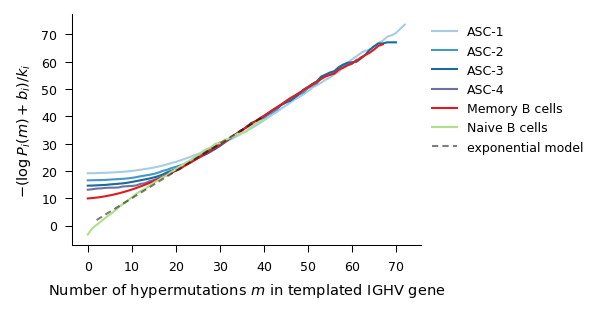

In [10]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
V=0.3
parameter_dict = {'state':[],'slope':[], 'rate':[], 'offset':[]}

bins = np.arange(0,max(all_v_mismatch+2))-0.5
bin_centers = (bins[1:] + bins[:-1])/2

p_celltype = pd.DataFrame(index=bin_centers)

for ct in sorted(df_hm_clean.celltype.unique()):


    data_distribution = df_hm_clean[(df_hm_clean.celltype==ct)].v_mismatch.values
    data_distribution, bins = np.histogram(data_distribution, bins = np.arange(0,max(all_v_mismatch+2))-0.5)
    data_distribution = data_distribution/data_distribution.sum()
    norm20 = data_distribution[:20].sum()
    data_distribution  = data_distribution
    data_ccdf = 1 - data_distribution.cumsum()
    log_data_ccdf = np.log(data_ccdf)

    total_cells = len(df_hm_clean[df_hm_clean.celltype==ct].v_mismatch.values)
    if ct == 'Naive B cells':
        begin = 2
    else:
        begin = 20
    cutoff = np.argwhere(log_data_ccdf < np.log(20/total_cells))[0][0]
    
    
    X=bin_centers[begin:cutoff].reshape(-1, 1)
    Y = -log_data_ccdf[begin:cutoff].reshape(-1, 1)
    reg = LinearRegression().fit(X,Y)
    # print(reg.score(X, Y))
    b = reg.coef_[0][0]
    a = reg.intercept_[0]
    print(ct, 1 - np.exp(-V*b), a)
    parameter_dict['state'].append(ct)
    parameter_dict['slope'].append(b)
    parameter_dict['offset'].append(a)
    parameter_dict['rate'].append( 1 - np.exp(-V*b))
    
    ax.plot(bin_centers[:cutoff], (-log_data_ccdf[:cutoff]-a)/b, color=bcelltype_colors_alt[ct], label=ct)
    if ct == "Naive B cells":
        pass
    else:
        pass
    
    p_celltype[ct] = total_cells* b * np.exp(-b*bin_centers-a)
line1, = ax.plot(X,X, color='k', alpha=0.5, label='exponential model')
line1.set_dashes((3,2))
# fig.tight_layout()

ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
ax.set_xlabel('Number of hypermutations $m$ in templated IGHV gene', fontsize=7)
ax.set_ylabel(r'$-(\log P_i(m)+b_i)/k_i$')
fig.savefig(f'{FIGURE_OUTDIR}/exponential_model_SI.pdf', bbox_inches='tight')
print(f'{FIGURE_OUTDIR}/exponential_model.pdf')


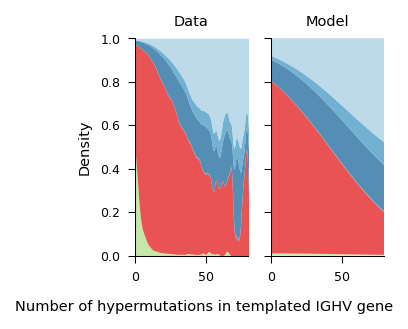

In [11]:
p_celltype_norm = (p_celltype.T/p_celltype.sum(axis=1)).T#.reset_index()

sorted_columns = sorted(p_celltype_norm.columns)[::-1]
p_celltype_norm = p_celltype_norm[sorted_columns]
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(2.25,2.))

ax[1].stackplot(p_celltype_norm.index, p_celltype_norm.T,colors=[bcelltype_colors_alt[x] for x in p_celltype_norm.columns], labels = p_celltype_norm.columns, alpha=0.75)
# ax[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
g = sns.kdeplot(data=df_hm_clean.sort_values('celltype'), x='v_mismatch', hue='celltype', palette=bcelltype_colors_alt, multiple='fill', lw=0, ax = ax[0], legend=False)
# sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xlim([0,80])
ax[0].set_title('Data', fontsize=7)
ax[1].set_title('Model', fontsize=7)
fig.tight_layout()
fig.supxlabel('Number of hypermutations in templated IGHV gene', fontsize=7, x = 0.42, y = -0.05)
fig.savefig(f'{FIGURE_OUTDIR}/stacked_density_celltype_data_vs_model.pdf', bbox_inches='tight')


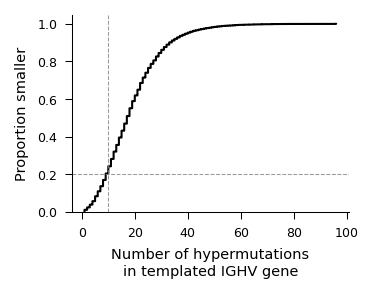

In [12]:
fig, ax=plt.subplots(figsize=(2.5,2))

sns.ecdfplot(df_hm_clean[(df_hm_clean.lineage_size>2)],x = 'v_mismatch', color='k', complementary=False, lw=1)
# ax.set_yscale('log')
ax.axvline(x=10, color='0.5', alpha=0.8, linestyle='dashed', lw=0.5)
ax.axhline(y=0.2, color='0.5', alpha=0.8, linestyle='dashed', lw=0.5)
ax.set_xlabel('Number of hypermutations\nin templated IGHV gene', fontsize=7)
ax.set_ylabel('Proportion smaller')
sns.despine(fig)
fig.tight_layout()
ax.set_ylim([0,1.05])
fig.savefig(f'{FIGURE_OUTDIR}/marginal_hm_m_distribution.pdf', bbox_inches='tight')

False    72417
True       456
Name: has_naive, dtype: int64


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/3933327997.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_abundance = lineage_composition.groupby(['binned_total', 'has_naive']).median().reset_index()
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/3933327997.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_permuted_abundance = lineage_composition_permuted.groupby(['binned_total', 'has_naive']).median().reset_index()


ASC-1
ASC-2
ASC-3
ASC-4
Naive B cells
Memory B cells


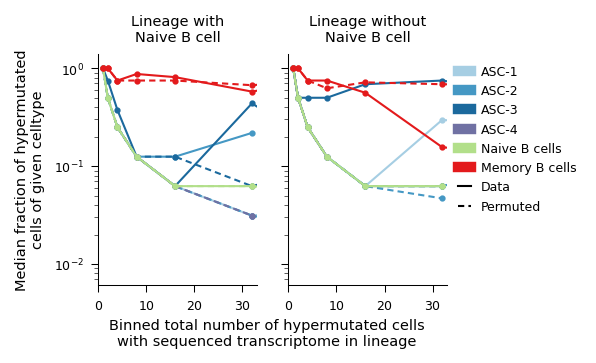

In [13]:
lineage_composition = df_hm_clean.groupby(['donor','lineage_id','celltype','vdj_sequence']).size().reset_index()
lineage_composition = lineage_composition.groupby(['donor','lineage_id','celltype'])['vdj_sequence'].nunique().reset_index()
lineage_composition = lineage_composition.pivot(index = ['lineage_id', 'donor'], columns = 'celltype', values='vdj_sequence')
lineage_composition['total'] = lineage_composition.sum(axis=1)
lineage_composition['binned_total'] = 2**np.round(np.log(lineage_composition.total)/np.log(2))
lineage_composition = lineage_composition.reset_index()
lineage_composition['has_naive'] = lineage_composition.reset_index().apply(lambda x: naive_lineage[(x.donor, x.lineage_id)], axis=1)
print(lineage_composition.has_naive.value_counts())

lineage_composition_permuted = df_hm_clean.groupby(['donor','lineage_id','celltype','vdj_sequence']).size().reset_index()
lineage_composition_permuted['permuted_celltype'] = np.random.permutation(lineage_composition_permuted['celltype'].values)
lineage_composition_permuted = lineage_composition_permuted.groupby(['donor','lineage_id','permuted_celltype'])['vdj_sequence'].nunique().reset_index()

lineage_composition_permuted = lineage_composition_permuted.pivot(index = ['lineage_id', 'donor'], columns = 'permuted_celltype', values='vdj_sequence')
lineage_composition_permuted['total'] = lineage_composition_permuted.sum(axis=1)
lineage_composition_permuted['binned_total'] = 2**np.round(np.log(lineage_composition_permuted.total)/np.log(2))
lineage_composition_permuted = lineage_composition_permuted.reset_index()

lineage_composition_permuted['has_naive'] = lineage_composition_permuted.reset_index().apply(lambda x: naive_lineage[(x.donor, x.lineage_id)], axis=1)
fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(3,2))
ax_naive_lineage = axes[0]
ax_nonnaive = axes[1]
ax_naive_lineage.set_yscale('log')
ax_naive_lineage.set_xlim([0,33])


mean_abundance = lineage_composition.groupby(['binned_total', 'has_naive']).median().reset_index()
mean_permuted_abundance = lineage_composition_permuted.groupby(['binned_total', 'has_naive']).median().reset_index()
axes[0].set_title('Lineage with\nNaive B cell')
axes[1].set_title('Lineage without\nNaive B cell')
#for col in ['ASC-1','ASC-2','ASC-3','ASC-4','Memory B cells']:
for col in ['ASC-1','ASC-2','ASC-3','ASC-4','Naive B cells', 'Memory B cells']:
    if col in bcelltype_colors_alt.keys():
        print(col)
        mean_abundance[col] = mean_abundance[col]/mean_abundance['binned_total']
        ax_naive_lineage.plot(mean_abundance.loc[mean_abundance.has_naive, 'binned_total'], 
                  mean_abundance.loc[mean_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        ax_nonnaive.plot(mean_abundance.loc[~mean_abundance.has_naive, 'binned_total'], 
                  mean_abundance.loc[~mean_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        

        mean_permuted_abundance[col] = mean_permuted_abundance[col]/mean_permuted_abundance['binned_total']
        line1,  = ax_naive_lineage.plot(mean_permuted_abundance.loc[mean_permuted_abundance.has_naive, 'binned_total'], 
                  mean_permuted_abundance.loc[mean_permuted_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        line2,  = ax_nonnaive.plot(mean_permuted_abundance.loc[~mean_permuted_abundance.has_naive, 'binned_total'], 
                  mean_permuted_abundance.loc[~mean_permuted_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        line1.set_dashes((3,2))
        line2.set_dashes((3,2))

        axes[1].plot([],[],lw=5,color=bcelltype_colors_alt[col], label=col)

        # ax_naive_lineage.plot(np.logspace(0,5,base=2), 1/np.logspace(0,5,base=2), color='k')
        # if col != 'Naive B cells':
            # sns.lineplot(mean_abundance[~mean_abundance.has_naive], x = 'binned_total', y = col, color=bcelltype_colors_alt[col], ax = ax[0], linestyle='dotted')
sns.despine(fig)
axes[1].plot([],[], lw=1, color='k', label='Data')
line1,  = axes[1].plot([],[], lw=1, color='k', label='Permuted')
line1.set_dashes((3,2))
axes[1].legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left', handlelength=1)
fig.supxlabel('Binned total number of hypermutated cells\nwith sequenced transcriptome in lineage', fontsize=7, y=-0.1)
axes[0].set_ylabel('Median fraction of hypermutated\ncells of given celltype', x=-0.2)
lineage_composition.groupby(['binned_total', 'has_naive']).size()
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/naive_lineage_composition.pdf', bbox_inches='tight')

1405
71083


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/417147963.py:10: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(1- counts_nl.cumsum()/counts_nl.sum())
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/417147963.py:16: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(1- counts_nn.cumsum()/counts_nn.sum())


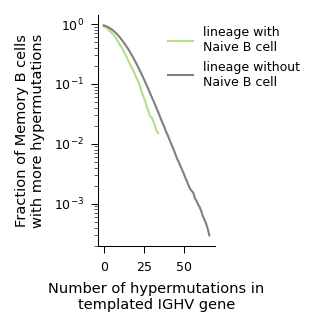

In [14]:
relevant_df = df_clean
fig, ax = plt.subplots(figsize=(1,2))
for ct, dark_col in [('Memory B cells','g')]:
    naive_lineage_memB = relevant_df[(relevant_df.celltype=='Memory B cells') & relevant_df.naive_lineage].v_mismatch
    non_naive_lineage_memB = relevant_df[(relevant_df.celltype=='Memory B cells') & ~(relevant_df.naive_lineage.astype(bool))].v_mismatch
    
    counts_nl, bins = np.histogram(naive_lineage_memB, bins=np.arange(0,80)-0.5)
    total_nl_cells = len(naive_lineage_memB)
    print(total_nl_cells)
    log_data_ccdf = np.log(1- counts_nl.cumsum()/counts_nl.sum())
    cutoff_nl = np.argwhere(log_data_ccdf < np.log(20/total_nl_cells))[0][0]

    counts_nn, bins = np.histogram(non_naive_lineage_memB, bins=np.arange(0,80)-0.5)
    total_nn_cells = len(non_naive_lineage_memB)
    print(total_nn_cells)
    log_data_ccdf = np.log(1- counts_nn.cumsum()/counts_nn.sum())
    cutoff_nn = np.argwhere(log_data_ccdf < np.log(20/total_nn_cells))[0][0]
    bin_centers = (bins[1:] + bins[:-1])/2.

    ax.plot(bin_centers[:cutoff_nl], (1- counts_nl.cumsum()/counts_nl.sum())[:cutoff_nl], color=bcelltype_colors_alt['Naive B cells'], label='lineage with\nNaive B cell')
    ax.plot(bin_centers[:cutoff_nn], (1- counts_nn.cumsum()/counts_nn.sum())[:cutoff_nn], color='0.5', label='lineage without\nNaive B cell')
ax.legend(loc='upper left', bbox_to_anchor=(0.5,1), frameon=False)
ax.set_yscale('log')
ax.set_ylabel('Fraction of Memory B cells\nwith more hypermutations')
ax.set_xlabel('Number of hypermutations in\ntemplated IGHV gene')
sns.despine(fig)
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/naive_lineage_hypermutation.pdf', bbox_inches='tight')

In [15]:
all_dist = df_clean.tissue.value_counts(normalize=True)
naive_dist = df_clean[df_clean.celltype=='Naive B cells'].tissue.value_counts(normalize=True)
hm_naive_dist = df_hm_clean[(df_hm_clean.celltype=='Naive B cells') & (df_hm_clean.v_mismatch < 30)].tissue.value_counts(normalize=True)

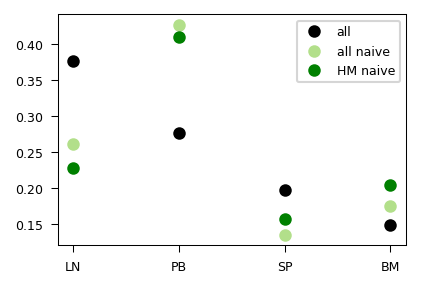

In [16]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(all_dist, 'o', color='k', label='all')
ax.plot(naive_dist, 'o', color=bcelltype_colors_alt['Naive B cells'], label='all naive')
ax.plot(hm_naive_dist, 'o', color='g', label='HM naive')
ax.legend(bbox_to_anchor=(1,1))

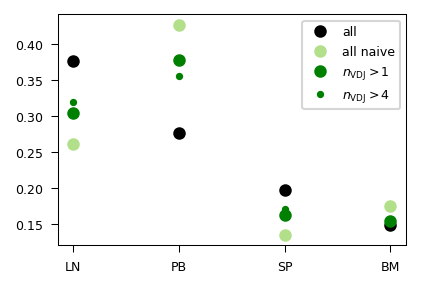

In [17]:
all_dist = df_clean.tissue.value_counts(normalize=True)
naive_dist = df_clean[df_clean.celltype=='Naive B cells'].tissue.value_counts(normalize=True)
hm_naive_dist = df_clean[(df_clean.celltype=='Naive B cells') & (df_clean.lineage_size > 1)].tissue.value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(all_dist, 'o', color='k', label='all')
# hm_naive_dist = df_clean[(df_clean.celltype=='Naive B cells') & (df_clean.lineage_size > 4)].tissue.value_counts(normalize=True)
# ax.plot(hm_naive_dist, '.', color='g', label=r'$n_\mathrm{VDJ}>4$')

ax.plot(naive_dist, 'o', color=bcelltype_colors_alt['Naive B cells'], label='all naive')
ax.plot(hm_naive_dist, 'o', color='g', label=r'$n_\mathrm{VDJ}>1$')

hm_naive_dist = df_clean[(df_clean.celltype=='Naive B cells') & (df_clean.lineage_size > 2)].tissue.value_counts(normalize=True)
ax.plot(hm_naive_dist, '.', color='g', label=r'$n_\mathrm{VDJ}>4$')

ax.legend(bbox_to_anchor=(1,1))


# calculate marginal celltype distributions for cells with GEX

In [18]:
best_fit_model = p_celltype_norm
best_fit_model.index = best_fit_model.index.astype(int)
best_fit_model = best_fit_model.iloc[1:,:]
best_fit_model

,Naive B cells,Memory B cells,ASC-4,ASC-3,ASC-2,ASC-1
1,0.010457,0.788301,0.000983,0.098962,0.017648,0.083650
2,0.010429,0.782887,0.001016,0.100986,0.018246,0.086436
3,0.010399,0.777361,0.001049,0.103032,0.018861,0.089298
4,0.010367,0.771722,0.001084,0.105098,0.019493,0.092236
5,0.010333,0.765969,0.001120,0.107184,0.020143,0.095252
...,...,...,...,...,...,...
92,0.002650,0.136261,0.006344,0.202159,0.118770,0.533815
93,0.002578,0.131997,0.006395,0.201221,0.119778,0.538031
94,0.002507,0.127844,0.006445,0.200251,0.120772,0.542180
95,0.002438,0.123799,0.006495,0.199250,0.121753,0.546265


In [19]:
empirical_distribution = df_hm_clean.groupby(['v_mismatch','celltype'])['vdj_sequence'].nunique().reset_index()
empirical_distribution['v_mismatch'] = empirical_distribution['v_mismatch'].astype(int)
empirical_distribution = empirical_distribution.pivot(index='v_mismatch', columns='celltype', values='vdj_sequence').fillna(0)
empirical_distribution = empirical_distribution[best_fit_model.columns]
total = empirical_distribution.sum(axis=1)
for col in empirical_distribution.columns:
    empirical_distribution[col] = (empirical_distribution[col]/total)
empirical_distribution

celltype,Naive B cells,Memory B cells,ASC-4,ASC-3,ASC-2,ASC-1
v_mismatch,,,,,,
1,0.541739,0.438351,0.000699,0.013971,0.000699,0.004541
2,0.284580,0.679900,0.001254,0.022148,0.003761,0.008358
3,0.222353,0.743137,0.000392,0.022353,0.001176,0.010588
4,0.164374,0.797111,0.000688,0.022696,0.003095,0.012036
5,0.120199,0.840066,0.000331,0.023510,0.004305,0.011589
...,...,...,...,...,...,...
87,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
88,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
89,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000


In [20]:
df_hm_clean['lineage_uid'] = df_hm_clean['donor'] + "_" + df_hm_clean['lineage_id'].fillna("").astype(str)

empirical_prob_df = df_hm_clean.groupby(['vdj_sequence','v_mismatch', 'lineage_uid', 'celltype','cb']).size()
lineage_sizes = df_hm_clean.groupby('lineage_uid')['vdj_sequence'].nunique()

empirical_prob_df = empirical_prob_df.reset_index()

for col in empirical_distribution:
    empirical_prob_df[col] = empirical_prob_df.apply(lambda x: empirical_distribution.loc[x.v_mismatch, col], axis=1)

In [21]:
def prob_any(l):
    probabilities = np.asarray(list(l))
    return 1 - np.product(1.-probabilities)

def expectation(l):
    probabilities = np.asarray(list(l))
    return np.sum(probabilities)

In [22]:
prob_any_in_lineage = empirical_prob_df.groupby(['lineage_uid'])[[col for col in empirical_distribution.columns]].agg(prob_any)
expected_cells_model = empirical_prob_df.groupby(['lineage_uid'])[[col for col in empirical_distribution.columns]].agg(expectation)
expected_cells_model['lineage_size'] = expected_cells_model.index.map(lineage_sizes)
expected_cells_model['lineage_size_binned'] = 2**round(np.log(expected_cells_model.lineage_size)/np.log(2))
expected_cells_model = expected_cells_model.groupby('lineage_size_binned').sum()
print(prob_any_in_lineage.sum())

Naive B cells      5822.894181
Memory B cells    58420.238964
ASC-4               130.892604
ASC-3              5729.212653
ASC-2              1553.251742
ASC-1              5333.822559
dtype: float64


In [23]:
empirical_count_any = empirical_prob_df.groupby(['lineage_uid','celltype']).size()
empirical_count_any = empirical_count_any.reset_index().pivot(index=['lineage_uid'], columns='celltype', values=0)
expected_cells_data = empirical_count_any.copy()
expected_cells_data['lineage_size'] = expected_cells_data.index.map(lineage_sizes)
expected_cells_data['lineage_size_binned'] = 2**round(np.log(expected_cells_data.lineage_size)/np.log(2))
expected_cells_data = expected_cells_data.groupby('lineage_size_binned').sum()
empirical_count_any = empirical_count_any > 0
empirical_count_any.sum(axis=0)


celltype
ASC-1              4908
ASC-2              1416
ASC-3              4350
ASC-4               124
Memory B cells    58536
Naive B cells      5722
dtype: int64

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_35539/3717719344.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


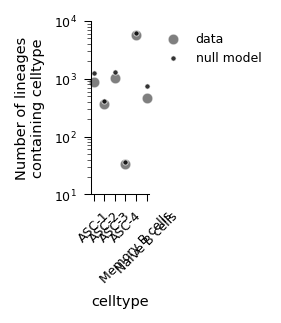

In [24]:
fig, ax = plt.subplots(figsize=(0.5,1.5))
at_least_2 = empirical_count_any.index.map(lineage_sizes) > 1
g=sns.scatterplot(empirical_count_any[at_least_2].sum(axis=0),marker='o', color='k', label='data', ax=ax, alpha=0.5, clip_on=False)
at_least_2 = prob_any_in_lineage.index.map(lineage_sizes) > 1
sns.scatterplot(prob_any_in_lineage[at_least_2].sum(axis=0),marker='.', color='k', label='null model', ax=ax, alpha=0.8, clip_on=False)

sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylim([10,10**4])
sns.despine(fig)
ax.set_ylabel('Number of lineages\ncontaining celltype')
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/lineage_compostion_celltype_any_cells.pdf')

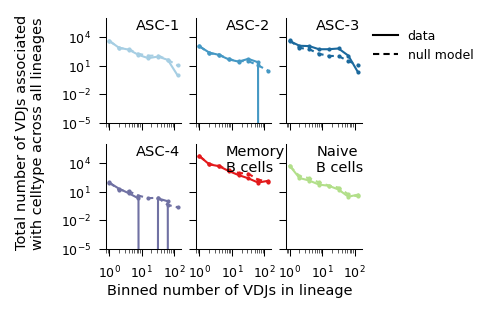

In [25]:
fig, axes = plt.subplots(2,3,figsize=(2.2,2), sharex=True, sharey=True)
axes = axes.flatten()
i = 0
for col in expected_cells_data.columns:
    if col == 'lineage_size':
        continue
    else:
        ax = axes[i]
        i+=1
    title = col.split(" ")[0]+"\n" + " ".join(col.split(" ")[1:])
    ax.text(0.4,1.,title, transform=ax.transAxes,fontsize=7,va='top', ha='left')
    ax.plot(expected_cells_data[col],'o-', color=bcelltype_colors_alt[col],markersize=1)
    line1, = ax.plot(expected_cells_model[col],'o-', color=bcelltype_colors_alt[col],markersize=1)
    line1.set_dashes((3,2))
    ax.set_yscale('log')
    ax.set_xscale('log')
fig.supxlabel('Binned number of VDJs in lineage', fontsize=7, y = -0.05)
fig.supylabel('Total number of VDJs associated\nwith celltype across all lineages', fontsize=7, x=-0.15)
axes[2].plot([],[], color='k', label='data')
line1,  = axes[2].plot([],[], color='k', label='null model')
line1.set_dashes((3,2))
axes[2].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
axes[0].set_ylim([10**-5,10**6])
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/lineage_compostion_celltype_total_cells.pdf', bbox_inches='tight')
